# Clusterizacion de las preguntas

## Trabajo 3.2

###  Usando Tfidf para la vectorizacion. Con preprosesamiento tipo2

A diferencia del trabajo 2, aca se consideran las preguntas, no todos los dialogos

Ademas, se dejan las preguntas repetidas para que tengan mas "peso"

Se usa la carpeta "Datos (modificaciones manuales)" donde se encuentar todas las entrevistas en formato correcto

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk import FreqDist
import os
import time
from nltk.tokenize import wordpunct_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import spacy
import re
from unidecode import unidecode
from numpy import save

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# para cargar las entrevistas
from Trabajo_1 import Entrevista

In [4]:
carpeta_entrevistas = "Datos (modificaciones manuales)"
carpeta_output = './/Resultados trabajo 3//'

### Lectura de datos

In [5]:
# guardas los objetos creados en una lista
entrevistas = []

# checar todos
for file in os.listdir('.\\' + carpeta_entrevistas):
    ruta_archivo = os.path.join('.\\' + carpeta_entrevistas, file)
    if os.path.isfile(ruta_archivo):
        # crear el objeto y meterlo a la lista
        entrevistas.append(Entrevista(carpeta_entrevistas, file, debug = 0))
        
num_entrevistas = len(entrevistas)
print(f'Se tienen {num_entrevistas} entrevistas')

Se tienen 38 entrevistas


### Obtener todas las preguntas

In [6]:
preguntas = []

for e in entrevistas:
    # añadir las preguntas de esta entrevista
    preguntas.extend(e.get_preguntas())


print(f'Se tienen {len(preguntas)} preguntas en total')
# por si se quiere la frecuencia de las preguntas mas adelante
fdist_preguntas = nltk.FreqDist(preguntas)

# tambien tenerlas en array, por si se nescesita
preguntas_np = np.array(preguntas)

Se tienen 3934 preguntas en total


### Procesamiento de las preguntas

Tipo 2 (En otros trabajos se consiera otro tipo de preprocesamiento)

In [7]:
# Obtener las stopwords en español
stopwords_es = stopwords.words('spanish')
# obtener signos de puntuacion
punctuation = list(string.punctuation) + ['¿', '?,']

# lista de tokens que no pasan el filtro
lista_eliminar = stopwords_es + punctuation

# pasar los paises al mismo nombre
paises_latam = ['salvador', 'honduras', 'guatemala', 'nicaragua']

# Cargar el modelo de idioma en español
nlp = spacy.load('es_core_news_sm')

def filtrar_tokens(tokens_list):
    # toma una lista de tokens
    # regresa los tokens sin stopwords y sin signos de puntuacion
    # solo regresa los tokens de cierto tipo
    # tambien se cambia el nombre de los paises
    
    
    # primero quitas puntuacion y acentos, y haces minusculas
    tokens_list = [unidecode(t).lower() for t in tokens_list if t.lower() not in lista_eliminar]
    
    
    # pasar de tokens a string
    string = ' '.join(tokens_list)
    
    # Procesar el texto con spaCy
    doc = nlp(string)
    

    tokens_filtrados = []
    # iterar con los tokens que crea scaCy
    for token in doc:
        # flitrar
        if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'VERB', 'ADV'] and not token.is_stop:
            tokens_filtrados.append(str(token).lower())
    
    
    # normalizal nombre de paises
    for idx, token in enumerate(tokens_filtrados):
        if token in paises_latam:
            tokens_filtrados[idx] = 'pais'
    
    # no se tienen tokens filtrados, delvover vacio
    if len(tokens_filtrados) == 0:
        return ['[VACIO]']
        
    return tokens_filtrados

In [8]:
preguntas_procesadas = [' '.join(filtrar_tokens((wordpunct_tokenize(p)))) for p in preguntas]

In [9]:
# ver un ejemplo
idx = 234
print(preguntas[idx])
print("-"*100)
print(preguntas_procesadas[idx])

¿Tú has tenido alguna vez, este… algún tipo de experiencia con algún lugar donde llegaste a buscar ayuda cuando te sentías triste, nervioso o nunca la has buscado?
----------------------------------------------------------------------------------------------------
algun tipo experiencia algun lugar llegaste buscar ayuda sentias triste nervioso buscado


### Vectorizaciones de las preguntas

In [10]:
print(f'Se tiene una lista de {len(preguntas)} preguntas')
print(f'Por lo que se quiere construir una matriz X de dimensiones: {len(preguntas)} x d')

Se tiene una lista de 3934 preguntas
Por lo que se quiere construir una matriz X de dimensiones: 3934 x d


In [11]:
start_time = time.time()

vectorizer = TfidfVectorizer(analyzer = 'word', norm = 'l2', ngram_range = (1, 3), min_df = 2)
X = vectorizer.fit_transform(preguntas_procesadas)
X = X.toarray()

print('Listo. Tiempo en segundos:', time.time() - start_time)

Listo. Tiempo en segundos: 0.06406903266906738


In [12]:
print(f'Se construyo una matriz X de dimensiones: {X.shape[0]} x {X.shape[1]}')

Se construyo una matriz X de dimensiones: 3934 x 5833


### Creacion de los clusters

In [13]:
k = 50

model = KMeans(n_clusters=k, n_init= 10, random_state= 10)
y = model.fit_predict(X)

In [14]:
# frecuencias de las etiquetas de los clusters
# es un diccionaro de pares (numero_cluster, cantidad de elmentos)
fdist_y = nltk.FreqDist(y)


# poner las frecuencias de clusters en una lista
# que es de pares (cluster, frecuencia)
clusters_frecuencia = [(key, fdist_y[key]) for key in fdist_y]
# ordenarla para que vaya del cluster_0 al ultimo cluster
clusters_frecuencia.sort()


# obtener los clusters y sus respectivas frecuencuias en listas separadas
clusters = [cluster_freq[0] for cluster_freq in clusters_frecuencia]
frecuencias = [cluster_freq[1] for cluster_freq in clusters_frecuencia]


### Ver frecuencias de los clusters


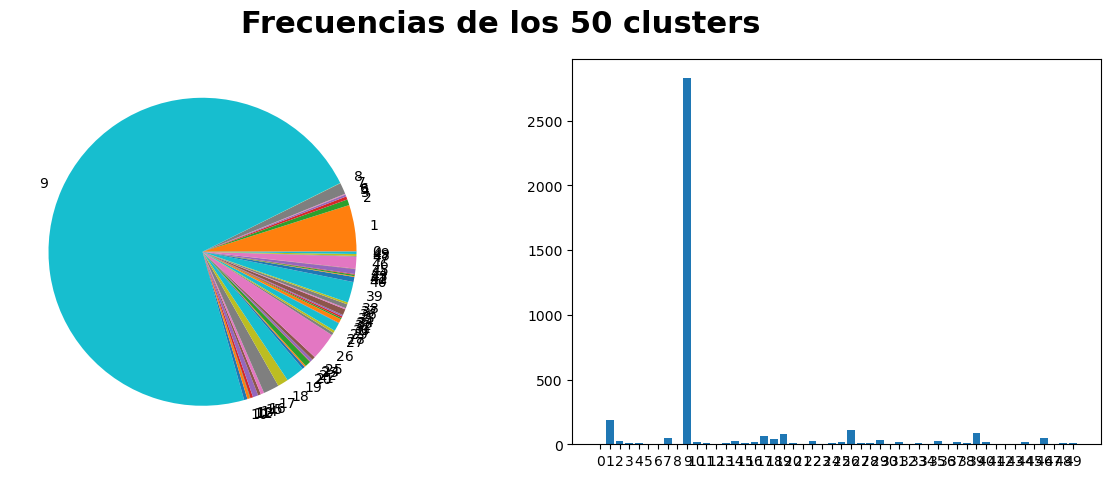

El cluster 8 tiene un elemento
El cluster 5 tiene un elemento
El 3.25% de los vectores del cluster mas grande (9) son el vector 0


In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

# pie cahrt
ax1.pie(frecuencias, labels=clusters)
# bar chart
ax2.bar(clusters, frecuencias)
ax2.set_xticks(clusters)

plt.suptitle(f'Frecuencias de los {k} clusters', fontsize=22, fontweight='bold')

# salvar
nombre_save= 'Frecuencia de clusters'

plt.show()

# ver si se tienen clusters con un elemento
clusters_uno = fdist_y.hapaxes()
for cluster_i in clusters_uno:
    print(f'El cluster {cluster_i} tiene un elemento')
    

# ver si un cluster esta compuesto de muchos vectores 0
cluster_mas_grande = fdist_y.most_common(1)[0][0]
vectores_cluster_gigante = X[y == cluster_mas_grande]
# porcentaje de vetores 0 en el cluster mas grande
v = sum((vectores_cluster_gigante==0).all(axis = 1))/len(vectores_cluster_gigante)
print('El {:0.2f}% de los vectores del cluster mas grande ({}) son el vector 0'.format(100*v, cluster_mas_grande))

### Creacion de un Data Frame con los resultados

Poner las preguntas, las preguntas procesadas y el cluster

In [16]:
assert len(preguntas) == len(y)

# hacer un df con la pregunta y el cluster
df_final = pd.DataFrame()

df_final['pregunta'] = preguntas
df_final['pregunta_procesada'] = preguntas_procesadas
df_final['cluster'] = y

# ordenar por cluster
df_final = df_final.sort_values('cluster')

# quitar repetidos
df_final = df_final.drop_duplicates(subset = 'pregunta')

# salvar el df 
df_final.to_csv(carpeta_output + 'clusters_3_2.csv', encoding='utf-8-sig', index=False)

In [17]:
# salvar los vectores
save(carpeta_output + 'X_3_2.npy', X)